# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, auc,roc_auc_score
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

Functional diversity is determined by traits such as diet, foraging strata, trophic level, activity cycle, litter size, generation length, habitat breadth, and body mass. These traits influence an animal’s ability to survive and adapt to different climates, playing a crucial role in ecosystem stability.

In [2]:
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1", na_values=[-999]).rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

dat.dtypes
# Drop columns that are not relevant to functional diversity or climate type variables
# Columns to drop
columns_to_drop = [
    'CranialCapacity',
    'InterbirthInterval',
    'HomeRange',
    'PopulationDensity',
    'SocialGrpSize',
    'Longevity'
]
# Columns to work on
#selected_columns = [
#    'AdultBodyMass', 'CranialCapacity', 'Diet_Invertebrates', 'Diet_Vertebrates',
#    'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds', 'Diet_Plants', 'Diet_Other', 'HabitatBreadth',
#    'ActivityCycle', 'ForagingStratum', 'GestationLength', 'LitterSize', 'InterbirthInterval',
#    'HomeRange', 'PopulationDensity', 'SocialGrpSize', 'Longevity', 'Dry', 'Humid', 'Montane',
#    'Subarid', 'Subhumid'
#]

# Drop the columns
mammal = dat.drop(columns=columns_to_drop)
mammal.head()

# Drop columns that have greater than 40% missing obs 
#df.isna().sum()
mammal_clean = mammal.dropna(axis=1, thresh=len(mammal)*0.6)
print(f"Final DataFrame shape: {mammal_clean.shape}\n")
#df_clean.isna().sum()
      

Final DataFrame shape: (214, 17)



In [3]:
dat.shape

(214, 24)

### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [4]:
# Check column types
dat.dtypes
# Check for NA values
mammal_clean.isna().sum()

AdultBodyMass          3
Diet_Invertebrates    15
Diet_Vertebrates      15
Diet_Fruits           15
Diet_Flowers          15
Diet_Seeds            15
Diet_Plants           15
Diet_Other            15
HabitatBreadth        26
ActivityCycle         22
ForagingStratum       24
LitterSize            83
Dry                    0
Humid                  0
Montane                0
Subarid                0
Subhumid               0
dtype: int64

In [5]:
# Select numeric columns
numeric_cols = mammal_clean.select_dtypes(include=['number']).columns
# Select categorical columns
cate_cols = mammal_clean.select_dtypes(include=['object']).columns

# Create imputer
knn_impute = KNNImputer(n_neighbors = 5)

# impute only numeric columns
impute_numeric = knn_impute.fit_transform(mammal_clean[numeric_cols])

# impute categorical columns
impute_object = mammal_clean[cate_cols].fillna(mammal_clean[cate_cols].mode().iloc[0])
# update df with imputed data

mammal_clean[numeric_cols] = impute_numeric
mammal_clean[cate_cols] = impute_object

# Check for na values in numeric columns
assert mammal_clean.isna().sum().sum() == 0, 'NA values found in dataframe'

mammal_clean.isna().sum()


/tmp/ipykernel_222881/876853130.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mammal_clean[numeric_cols] = impute_numeric
/tmp/ipykernel_222881/876853130.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mammal_clean[cate_cols] = impute_object


AdultBodyMass         0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
Dry                   0
Humid                 0
Montane               0
Subarid               0
Subhumid              0
dtype: int64

### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [12]:
# Create nClimates column for target variable
mammal_clean['nClimates'] = mammal_clean[['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']].sum(axis=1)

# Drop climate columns
mammal_clean.drop(['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'], axis =1, inplace=True)

mammal_clean.dtypes

KeyError: "None of [Index(['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'], dtype='object')] are in the [columns]"

In [16]:
# Initialize space for columns
encoded_columns = {}
# Encode categorical variables
for column in mammal_clean.select_dtypes(include=['object','bool']).columns:
    encoder = LabelEncoder()
    encoded_columns[column] = encoder.fit_transform(mammal_clean[column])
# Update dataframe
for column, encoded_values in encoded_columns.items():
    mammal_clean[column] = encoded_values
# Check for successful encoding    
mammal_clean.dtypes
# Check for class distribution
mammal_clean['nClimates'].value_counts()

nClimates
2.0    49
3.0    46
1.0    45
5.0    45
4.0    29
Name: count, dtype: int64

In [14]:
# Define target and feature variables
y = mammal_clean['nClimates']
X = mammal_clean.drop('nClimates', axis =1)

# Split data with random states
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 808)



### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

In [21]:
# Create decision tree model
tree = DecisionTreeRegressor(max_depth=5, random_state=808)
# Train model
tree.fit(X_train, y_train)
# Make prediction
tree_preds = tree.predict(X_test)

# plot tree
plt.figure(figsize=(12,15),dpi=700)
plot_tree(tree, feature_names = X.columns, class_names = mammal_clean['nClimates'], filled = True, rounded =True)
plt.title("Decision Tree with Max Depth of 5")

Text(0.5, 1.0, 'Decision Tree with Max Depth of 5')

Based on the way this tree looks, what would you guess the most important variable to be?

The most important variable is the root feature: `Diet_plants`

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [25]:
# Define parameter grid
param_grid = {
    "n_estimators": [50, 100, 200], # number of trees
    "max_depth": [3,4,5,6,7],
    "max_features": ["sqrt", 6, None], # M_try
    "min_samples_split": [2,5,10],
    "min_samples_leaf": [1,2,4] 
}

# Build model
rf = RandomForestRegressor()

# Initialize gridsearch
gs = GridSearchCV(rf, param_grid = param_grid, cv=5, scoring = "neg_mean_squared_error", n_jobs = -1, return_train_score = True)

# Carry out the search
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 6, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [28]:
# Get best performing hyperparamter with mse
gs.best_params_

{'max_depth': 7,
 'max_features': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 50}

In [29]:
# Define best estimator
best_rf = gs.best_estimator_
# train with best estimator
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, max_features=6, min_samples_split=10,
                      n_estimators=50)

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [38]:
# Make Predictions
rf_preds = best_rf.predict(X_test)

# print best param
gs.best_params_

{'max_depth': 7,
 'max_features': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 50}

In [39]:
# Compute and print the mse to evaluate model performance
rf_mse = mean_squared_error(y_test, rf_preds)
print(f"Mean Squared Error for Random Forest = {rf_mse}")

Mean Squared Error for Random Forest = 1.3743091654433173


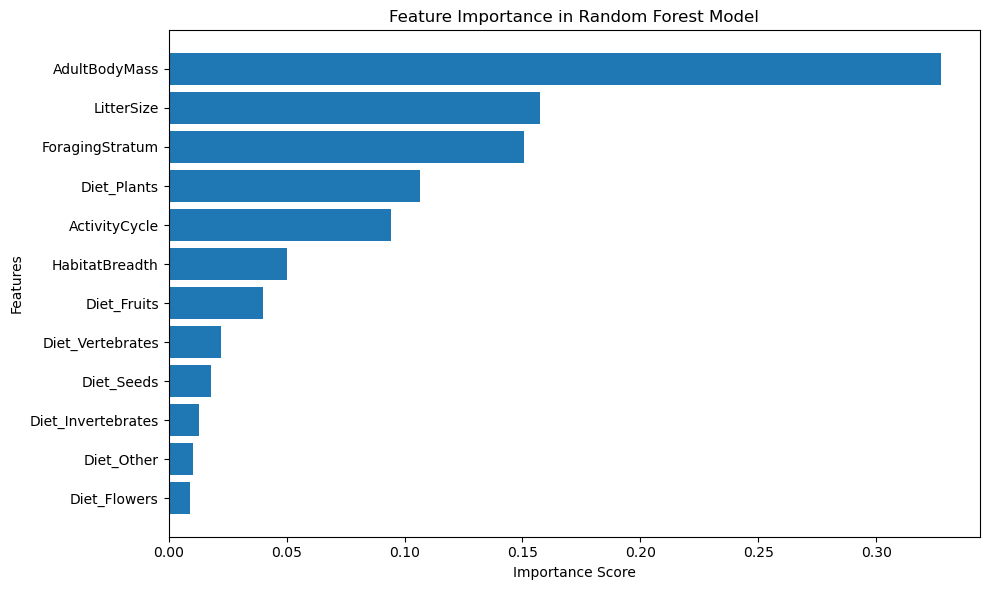

In [47]:
# Extract feature importance from rf trained model
imp = gs.best_estimator_.feature_importances_

# Create a DataFrame of feature importances
feature_imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': imp
}).sort_values('importance', ascending=True)

# Plot histogram of importance
plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['feature'], feature_imp_df['importance'])
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

In [52]:
# Calculate MSE
tree_mse = mean_squared_error(y_test, tree_preds)

# Compare results
print(f"MSE for Random Forest Model is {rf_mse}, \nMSE for single Decision Tree is {tree_mse}")

MSE for Random Forest Model is 1.3743091654433173, 
MSE for single Decision Tree is 2.0601525141415333


Random Forest Regressor performed better under Mean Square Error evaluation. From the random forest model, `AdultBodyMass`, `LitterSize`, `ForagingStratum`, `Diet_Plants` and `Activity Cycle` are the top five most influencial features on species' climate adaptability. 